Project: /overview/_project.yaml
Book: /overview/_book.yaml

<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="画像を読み込んで前処理する" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.data.Dataset"/>
<meta itemprop="property" content="tf.data.experimental.cardinality"/>
<meta itemprop="property" content="tf.image.resize"/>
<meta itemprop="property" content="tf.io.decode_jpeg"/>
<meta itemprop="property" content="tf.io.read_file"/>
<meta itemprop="property" content="tf.keras.Sequential"/>
<meta itemprop="property" content="tf.keras.layers.Conv2D"/>
<meta itemprop="property" content="tf.keras.layers.Dense"/>
<meta itemprop="property" content="tf.keras.layers.Flatten"/>
<meta itemprop="property" content="tf.keras.layers.MaxPooling2D"/>
<meta itemprop="property" content="tf.keras.layers.Rescaling"/>
<meta itemprop="property" content="tf.keras.losses.SparseCategoricalCrossentropy"/>
<meta itemprop="property" content="tf.keras.utils.get_file"/>
<meta itemprop="property" content="tf.keras.utils.image_dataset_from_directory"/>
<meta itemprop="property" content="tf.math.argmax"/>
<meta itemprop="property" content="tf.strings.split"/>
</div>

# 画像を読み込んで前処理する

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

このチュートリアルでは、次の 3 つの方法で画像データセットを読み込んで前処理する方法を説明します。

- まず、高レベルの Keras 前処理ユーティリティ (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory"><code>tf.keras.utils.image_dataset_from_directory</code></a>) とレイヤー（` tf.keras.layers.Rescaling {/ code1}など）を使用してディスク上の画像のディレクトリを読み取ります。`
- 次に、[tf.data ](../../guide/data.ipynb) を使用して、独自の入力パイプラインを最初から作成します。
- 最後に、[TensorFlow Datasets](https://www.tensorflow.org/datasets) で利用可能な大きな[カタログ](https://www.tensorflow.org/datasets/catalog/overview)からデータセットをダウンロードします。

## 設定

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2024-01-11 17:49:10.757170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 17:49:10.757212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 17:49:10.758656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0


### 花のデータセットをダウンロードする

このチュートリアルでは、数千枚の花の写真のデータセットを使用します。花のデータセットにはクラスごとに 1 つずつ、計 5 つのサブディレクトリが含まれています。

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

注意: すべての画像は CC-BY のライセンス下にあります。作成者のリストは LICENSE.txt ファイルをご覧ください。

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


ダウンロードが完了すると（218 MB）、花の写真のコピーを使用できるようになります。画像の数は合計 3,670 個です。

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


各ディレクトリには、その種の花の画像が含まれています。以下は、バラのディレクトリです。

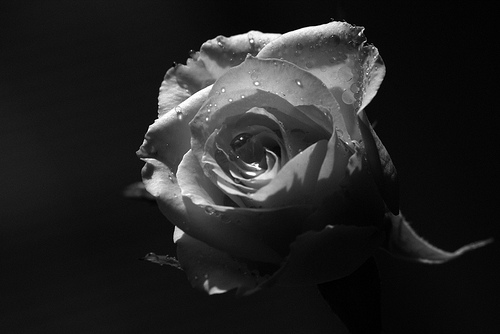

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

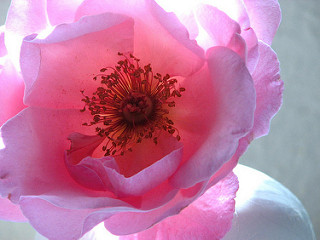

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Keras ユーティリティを使用してデータを読み込む

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory"><code>tf.keras.utils.image_dataset_from_directory</code></a>  ユーティリティを使用して、これらの画像をディスクから読み込みましょう。

### データセットを作成する

ローダーのいくつかのパラメーターを定義します。

In [8]:
batch_size = 32
img_height = 180
img_width = 180

モデルを開発するときは、検証 Split を使用することをお勧めします。ここでは、画像の 80％ をトレーニングに使用し、20％ を検証に使用します。

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.


Using 734 files for validation.


クラス名はこれらのデータセットの `class_names` 属性にあります。

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### データを視覚化する

以下はトレーニングデータセットの最初の 9 枚の画像です。

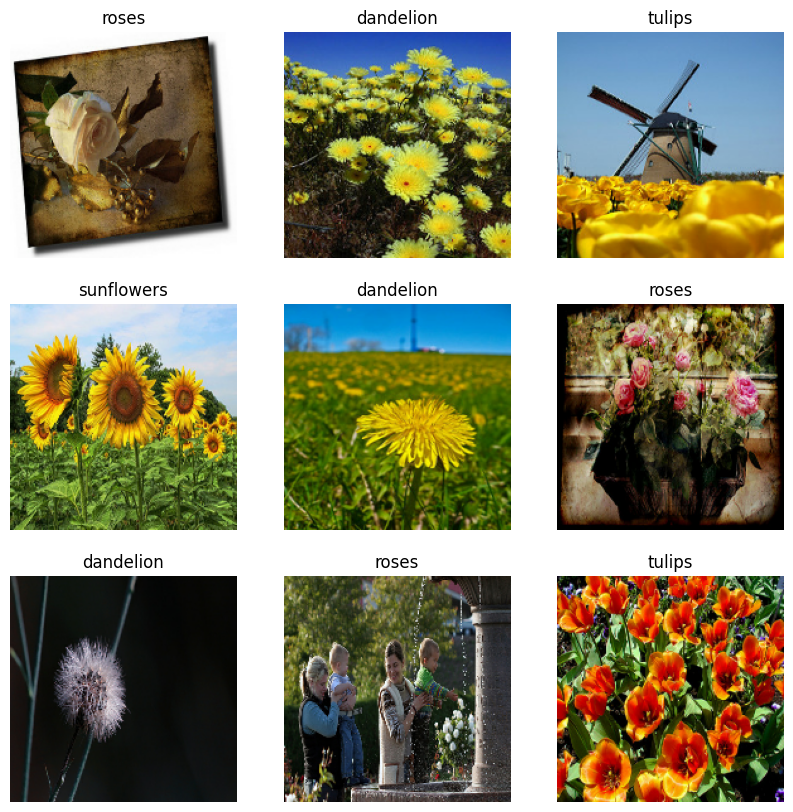

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

これらのデータセットを `model.fit` に渡すことで、モデルをトレーニングできます（このチュートリアルの後の方で説明しています）。また、手動でデータセットを反復し、画像のバッチを取得することもできます。

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` は、形状 `(32, 180, 180, 3)` のテンソルです。これは、形状 `180x180x3` の 32 枚の画像のバッチです（最後の次元はカラーチャンネル RGB を参照します）。`label_batch` は、形状 `(32,)` のテンソルであり、これらは 32 枚の画像に対応するラベルです。

これらのいずれかのテンソルで `.numpy()` を呼び出すと、`numpy.ndarray` に変換できます。

### データを標準化する

RGB チャネル値は `[0, 255]` の範囲にあり、ニューラルネットワークには理想的ではありません。一般に、入力値は小さくする必要があります。

ここでは、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling"><code>tf.keras.layers.Rescaling</code></a> を使用して、値を `[0, 1]` の範囲に標準化します。

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

このレイヤーを使用するには 2 つの方法があります。<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map"><code>Dataset.map</code></a> を呼び出すことにより、データセットに適用できます。

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


または、モデル定義内にレイヤーを含めてデプロイを簡素化できます。ここでは 2 番目のアプローチを使用します。

注意: ピクセル値を `[-1,1]` にスケーリングする場合は、代わりに `tf.keras.layers.Rescaling(1./127.5, offset=-1)` を記述できます。

注意：以前は、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory"><code>tf.keras.utils.image_dataset_from_directory</code></a> の `image_size` 引数を使用して画像のサイズを変更しました。モデルにサイズ変更ロジックも含める場合は、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing"><code>tf.keras.layers.Resizing</code></a> レイヤーを使用できます。

### データセットを構成してパフォーマンスを改善する

I/O がブロックされることなくディスクからデータを取得できるように、必ずバッファ付きプリフェッチを使用します。これらは、データを読み込むときに使用する必要がある 2 つの重要な方法です。

- <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache"><code>Dataset.cache</code></a> は、最初のエポック中に画像をディスクから読み込んだ後、メモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。
- <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch"><code>Dataset.prefetch</code></a> はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、[Better performance with the tf.data API](../../guide/data_performance.ipynb) の *プリフェッチ*を参照してください。

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### モデルをトレーニングする

完全を期すために、準備したデータセットを使用して単純なモデルをトレーニングする方法を示します。

[Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、それぞれに最大プーリング層 (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D"><code>tf.keras.layers.MaxPooling2D</code></a>)を持つ 3 つの畳み込みブロック (<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D"><code>tf.keras.layers.MaxPooling2D</code></a>) で構成されます。完全に接続された層（<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense"><code>tf.keras.layers.Dense</code></a>）の上には 128 ユニットがあり、ReLU 活性化関数 (`'relu'`) によって活性化されます。このモデルはまったく調整されていません。目標は、作成したデータセットを使用してメカニズムを表示することです。画像分類の詳細については、[画像分類](../images/classification.ipynb)チュートリアルをご覧ください。

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam"><code>tf.keras.optimizers.Adam</code></a> オプティマイザと<a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy"><code>tf.keras.losses.SparseCategoricalCrossentropy</code></a> 損失関数を選択します。各トレーニングエポックのトレーニングと検証の精度を表示するには、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile"><code>Model.compile</code></a> に `metrics` 引数を渡します。

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

注意: このチュートリアルが素早く実行するように、いくつかのエポックのみをトレーニングします。 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


I0000 00:00:1704995364.370476   13605 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 [==============================] - 8s 41ms/step - loss: 1.2628 - accuracy: 0.4697 - val_loss: 1.0797 - val_accuracy: 0.5586


Epoch 2/3


92/92 [==============================] - 2s 24ms/step - loss: 0.9964 - accuracy: 0.5943 - val_loss: 0.9464 - val_accuracy: 0.6226


Epoch 3/3


92/92 [==============================] - 2s 24ms/step - loss: 0.8521 - accuracy: 0.6751 - val_loss: 0.9259 - val_accuracy: 0.6376


注意: また、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit"><code>Model.fit</code></a> を使用する代わりに、カスタムトレーニングループを記述することもできます。詳細については、[トレーニングループを最初から記述する](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)をご覧ください。

トレーニングの精度に比べ、検証の制度が低いことに気づくでしょう。これは、モデルが過適合になっていることを示しています。過適合とそれを緩和する方法については、こちらの[チュートリアル](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)をご覧ください。

## <a href="https://www.tensorflow.org/api_docs/python/tf/data"><code>tf.data</code></a> を使用してより精密に制御する

上記の Keras 前処理ユーティリティ、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory"><code>tf.keras.utils.image_dataset_from_directory</code></a> は画像のディレクトリから <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset"><code>tf.data.Dataset</code></a> を作成する便利な方法です。

より細かく制御するには、<code>tf.data</code> を使用して独自の入力パイプラインを記述することができます。このセクションでは、前にダウンロードした TGZ ファイルのファイルパスを使ってこれを作成する方法を説明します。

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/daisy/13977181862_f8237b6b52.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/176458518_f81d4bff8e.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/5037790727_57c527494f.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/tulips/924782410_94ed7913ca_m.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/19359539074_d7e32e6616_n.jpg'


ファイルのツリー構造を使用して `class_names` リストを作成できます。

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


データセットをトレーニング用と検証用に分割します。

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

次のようにして、各データセットの長さを出力します。

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


ファイルパスを `(img, label)` ペアに変換する短い関数を記述します。

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map"><code>Dataset.map</code></a> を使用して、`image, label` ペアのデータセットを作成します。

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### 基本的な訓練手法

このデータセットを使ってモデルの訓練を行うには、データが

- よくシャッフルされ
- バッチ化され
- 限りなく繰り返され

これらの特徴量は、<a href="https://www.tensorflow.org/api_docs/python/tf/data"><code>tf.data</code></a> API を使って追加できます。詳細については、[入力パイプラインのパフォーマンス](../../guide/performance/datasets.ipynb)ガイドをご覧ください。

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### データを視覚化する

このデータセットは、前に作成したデータセットと同様に視覚化することができます。

2024-01-11 17:49:35.090157: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


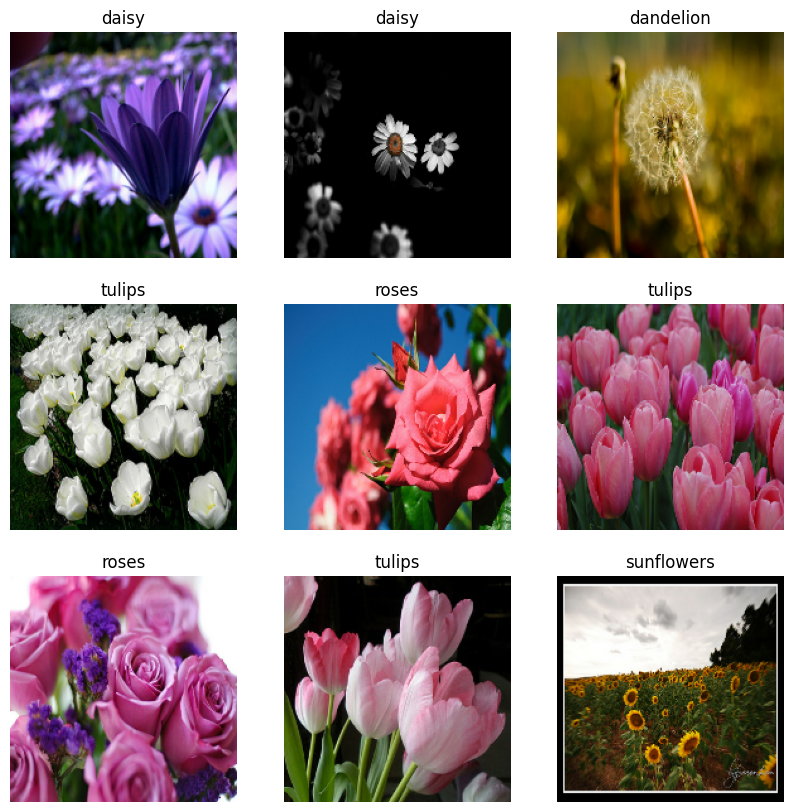

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### モデルのトレーニングを続ける

これで、上記の <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory"><code>tf.keras.utils.image_dataset_from_directory</code></a> で作成したデータセットに似た <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset"><code>tf.data.Dataset</code></a> を手動でビルドすることができました。これを使用して、モデルのトレーニングを続けることができます。前と同様に、実行時間を短縮するために、いくつかのエポックのみをトレーニングします。

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


92/92 [==============================] - 3s 28ms/step - loss: 0.7517 - accuracy: 0.7129 - val_loss: 0.6534 - val_accuracy: 0.7698


Epoch 2/3


92/92 [==============================] - 2s 24ms/step - loss: 0.5668 - accuracy: 0.7919 - val_loss: 0.6481 - val_accuracy: 0.7711


Epoch 3/3


92/92 [==============================] - 2s 25ms/step - loss: 0.3670 - accuracy: 0.8696 - val_loss: 0.8025 - val_accuracy: 0.7289


## TensorFlow Datasets を使用する

ここまで、このチュートリアルはディスクからデータを読み込むことに焦点を当ててきました。大規模な[カタログ](https://www.tensorflow.org/datasets/catalog/overview)（[TensorFlow Datasets](https://www.tensorflow.org/datasets) のカタログ）でダウンロードしやすいデータセットをブラウズし、使用するデータセットを探すこともできます。

前はディスクから Flowers データセットを読み込みましたが、今度は TensorFlow Datasets を使って、そのデータセットをインポートしてみましょう。

TensorFlow Datasets を使用して、Flowers [データセット](https://www.tensorflow.org/datasets/catalog/tf_flowers)をダウンロードします。

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Flowers データセットには 5 つのクラスがあります。

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


データセットから画像を 1 つ取得します。

2024-01-11 17:49:45.341325: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


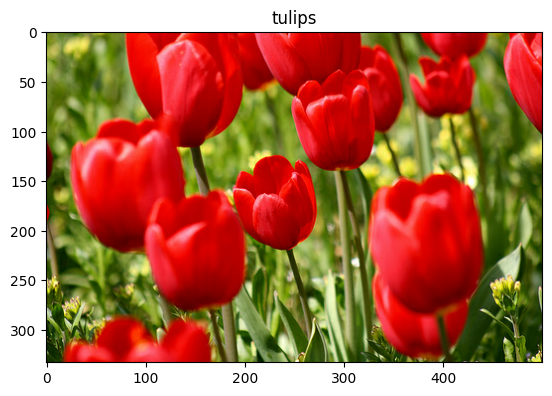

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

前と同様に、各データセットでバッチ処理、シャッフル、トレーニングの構成、および、セットのテストを実行して、パフォーマンスのチューニングを行います。

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

Flowers データセットと TensorFlow Detasets を使用した完全な例は、[データ拡張](../images/data_augmentation.ipynb)のチュートリアルをご覧ください。

## 次のステップ

このチュートリアルでは、ディスクから画像を読み込む 2 つの方法について説明しました。初めに、Keras 前処理レイヤーとユーティリティを使用して、画像データセットの読み込みと前処理を行う方法を学習しました。次に、<a href="https://www.tensorflow.org/api_docs/python/tf/data"><code>tf.data</code></a> を使用して、最初から入力パイプラインを記述する方法を学習しました。そして最後に、TensorFlow Detasets からデータセットをダウンロードする方法を学習しました。

次のステップとして、

- <a class="_active_edit_href" href=""></a><a>データ拡張を適用する方法</a>を学習しましょう。
- <code>tf.data</code> の詳細については、 <a>tf.data: TensorFlow 入力パイプラインをビルドする</a> ガイドをご覧ください。